In [1]:
import jax
import flax
from jax import numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os,sys
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler


sys.path.append('../jtils')
sys.path.append('../diffusions')

from jtils.batch_ops import batch_mul, batch_add
from jtils.datasets.two_dim import load_twodim
from jtils.datasets.tf.datasets import load_tfds
from jtils.plot import plot_img, plot_2d


from diffusions.training import get_loss_fn, get_step_fn, init_training_state, optimization_manager
from diffusions.model_ioputs import DiffusionModelInput, ModelConfig
from diffusions.diffusion_spec.discrete_ou import DiscreteOU
from diffusions.models.mlp import MLPNet
from diffusions.model_utils import get_model_fn

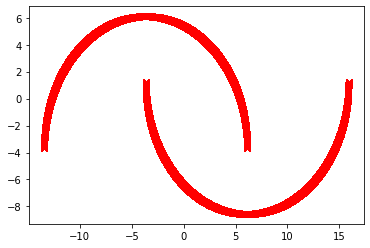

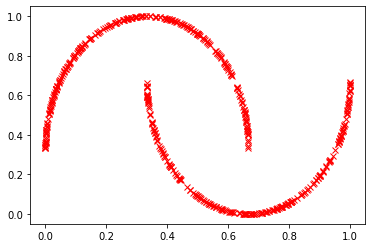

In [2]:
train_data = load_twodim(num_samples=10**6, dataset='moon')
plot_2d(train_data,'rx')
plt.show()
scalar = MinMaxScaler()
train_data = scalar.fit_transform(train_data)
ds = tf.data.Dataset.from_tensor_slices(tensors=train_data).batch(512).batch(1).repeat()

def process_fn(i):
    return {'x_0': i}

ds = ds.map(process_fn)
ds_iter = iter(ds)

batch = next(ds_iter)
plot_2d(batch['x_0'][0],'rx')
plt.show()

In [3]:
# Model to train, dependent on data modality
rng = jax.random.PRNGKey(0)
model_config = ModelConfig(t_pos_dim=128, t_embed_dim=128, x_embed_dim=128, joint_hidden_dim=128)
model = MLPNet(model_config)

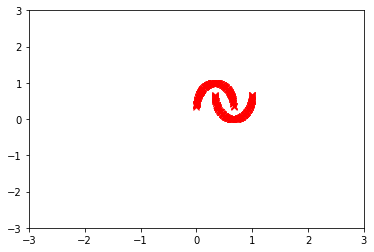

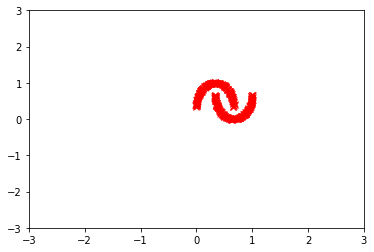

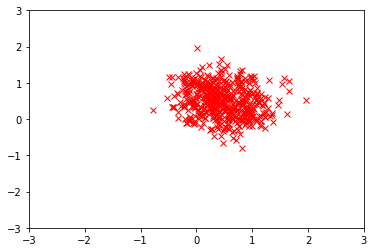

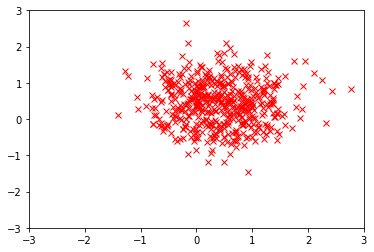

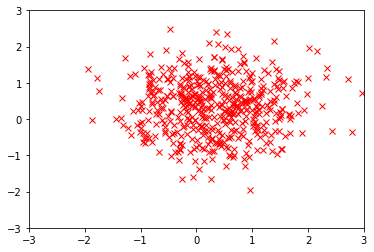

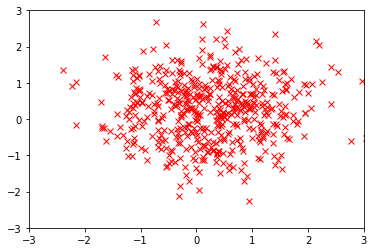

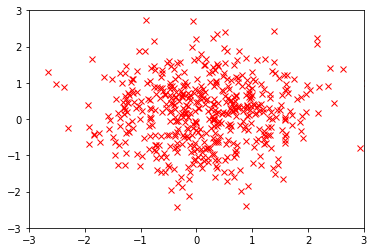

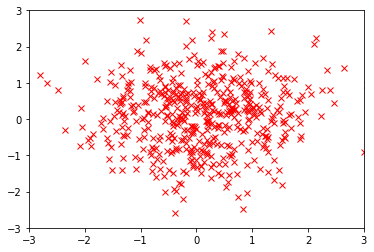

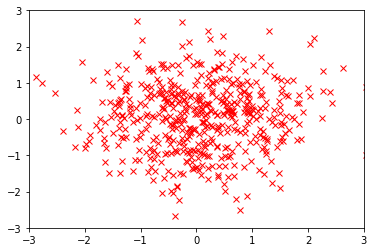

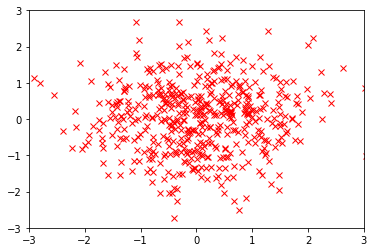

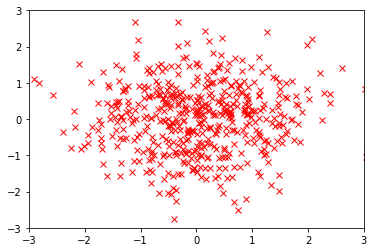

In [4]:
# Forward backward diffusion specification, most of the customisation
# - forward_sample
# - pointwise_loss
# - simulate_reverse_diffusion
sde = DiscreteOU()

x_0 = next(ds_iter)['x_0'][0].numpy()

plt.xlim(-3,3)
plt.ylim(-3,3)
plot_2d(x_0, 'rx')
plt.show()
        
        
for t in range(sde.N):
    if t % 100 == 0:
        t = t * jnp.ones((x_0.shape[0],), dtype=jnp.int32)
        x_t = sde.sample_x(rng, x_0, t).x_t
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plot_2d(x_t, 'rx')
        plt.show()
        

In [5]:
optimize_fn = optimization_manager(warmup=100, grad_clip=1.)
train_state = init_training_state(rng=rng, 
                        model=model,
                        input_shapes={'x_t':[1,2], 't':[1]},
                        optimizer=flax.optim.Adam(),
                        lr=1e-3,
                        ema_rate=0.99)

In [6]:
def train(train_state, model, sde, optimize_fn, num_iter=5*10**3, seed=0):
    rng = jax.random.PRNGKey(seed)
    step_fn = get_step_fn(model, sde, optimize_fn)
    p_step_fn = jax.pmap(step_fn, axis_name='batch')

    pstate = flax.jax_utils.replicate(train_state)
    
    for it in range(num_iter):
        batch = next(ds_iter)
        batch = jax.tree_map(lambda x: x.numpy(), batch)

        rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        next_rng = jnp.asarray(next_rng)
        carry_state = (next_rng, pstate)
        (_, pstate), ploss = p_step_fn(carry_state, batch)

        if it%10**3==0:
            print(it, ploss)
            
    return flax.jax_utils.unreplicate(pstate)

In [7]:
state = train_state

In [8]:
state = train(state, model, sde, optimize_fn, num_iter=10**4)

0 [0.22323343]
1000 [0.1002835]
2000 [0.09863393]
3000 [0.11976023]
4000 [0.09332384]
5000 [0.10464147]
6000 [0.10790143]
7000 [0.10353625]
8000 [0.10005274]
9000 [0.09416974]


In [9]:
model_fn = get_model_fn(model, state.ema_params)
backward_fn = sde.get_simulate_reverse_diffusion_fn(model_fn)

x_T = jax.random.normal(rng, (10**3,2))
out = backward_fn(rng, x_T)

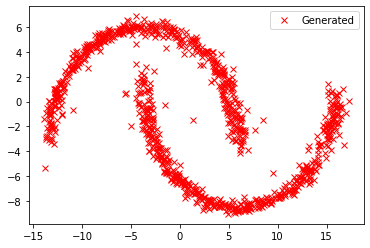

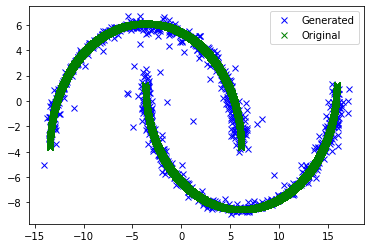

In [12]:
sampled_x_0 = out[0]
sampled_x_0 = scalar.inverse_transform(sampled_x_0)
plot_2d(sampled_x_0,'rx', label='Generated')
plt.legend()
plt.show()

sampled_x_0 = out[1]
sampled_x_0 = scalar.inverse_transform(sampled_x_0)
plot_2d(sampled_x_0,'bx', label='Generated')

original_data = scalar.inverse_transform(train_data)
plot_2d(original_data, 'gx', label='Original')
plt.legend()
plt.show()